# 정책 성능 비교 노트북

이 노트북에서는 DRL 모델과 베이스라인 정책들(Primary-Only, NPCA-Only, Random)의 성능을 비교분석합니다.

## Step 1: 라이브러리 및 모듈 Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import time
from collections import defaultdict

# 프로젝트 모듈들 import - Semi-MDP 환경 사용
import sys
sys.path.append('.')
from drl_framework.network import DQN
from drl_framework.configs import PPDU_DURATION_VARIANTS, PPDU_DURATION, RADIO_TRANSITION_TIME, OBSS_GENERATION_RATE
# Semi-MDP 환경 import
from npca_semi_mdp_env import NPCASemiMDPEnv

# 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

print("✅ 모든 라이브러리 import 완료! (Semi-MDP 환경 사용)")
print(f"PyTorch version: {torch.__version__}")

✅ 모든 라이브러리 import 완료! (Semi-MDP 환경 사용)
PyTorch version: 2.2.0


## Step 2: 베이스라인 정책들 정의

In [2]:
class BaselinePolicies:
    """Semi-MDP 환경에 맞는 베이스라인 정책들"""
    
    @staticmethod
    def primary_only(obs_dict):
        """항상 Primary 채널에서 대기 (Stay = 0)"""
        return 0
    
    @staticmethod 
    def npca_only(obs_dict):
        """항상 NPCA로 스위치 (Switch = 1)"""
        return 1
    
    @staticmethod
    def random_policy(obs_dict):
        """랜덤 액션 선택"""
        return np.random.randint(0, 2)
    
    @staticmethod
    def smart_threshold(obs_dict, threshold=50):
        """임계값 기반 정책 (OBSS 남은 시간 > threshold이면 스위치)"""
        obss_remain = obs_dict.get('obss_remaining', 0)
        return 1 if obss_remain > threshold else 0
    
    @staticmethod
    def adaptive_cw(obs_dict):
        """CW 인덱스 기반 적응형 정책 (높은 충돌 시 스위치)"""
        cw_index = obs_dict.get('cw_index', 0)
        obss_remain = obs_dict.get('obss_remaining', 0)
        # CW가 높고 OBSS가 길면 스위치
        return 1 if (cw_index >= 3 and obss_remain > 30) else 0
    
    @staticmethod
    def obss_frequency_based(obs_dict):
        """OBSS 빈도 기반 정책"""
        obss_freq = obs_dict.get('obss_frequency', np.array([0.0]))[0]
        return 1 if obss_freq > 0.3 else 0

def dict_to_legacy_vector(obs_dict):
    """Semi-MDP Dict 관찰을 기존 4차원 벡터로 변환 (DRL 모델 호환성)"""
    return [
        float(obs_dict.get('obss_remaining', 0)),     # OBSS 남은 시간
        float(obs_dict.get('current_slot', 1)),       # 현재 슬롯 (radio transition time 대용)
        33.0,  # tx_duration (고정값, PPDU_DURATION)
        float(obs_dict.get('cw_index', 0))            # CW 인덱스
    ]

print("🎯 Semi-MDP용 베이스라인 정책들 준비 완료!")
print("📐 관찰 변환 함수 준비 완료!")

🎯 Semi-MDP용 베이스라인 정책들 준비 완료!
📐 관찰 변환 함수 준비 완료!


## Step 3: DRL 모델 로더 클래스

In [3]:
class DRLModelLoader:
    """DRL 모델 로드 및 Semi-MDP 환경 관리 클래스"""
    
    def __init__(self):
        self.device = torch.device('cpu')
        self.loaded_models = {}
    
    def find_models(self, model_dir='./obss_comparison_results'):
        """사용 가능한 모델들 찾기"""
        model_dir = Path(model_dir)
        model_files = list(model_dir.glob('*/model.pth'))
        
        models_info = []
        for model_file in model_files:
            try:
                checkpoint = torch.load(model_file, map_location=self.device, weights_only=False)
                info = {
                    'path': model_file,
                    'name': model_file.parent.name,
                    'obss_duration': checkpoint.get('obss_duration', 'unknown'),
                    'ppdu_variant': checkpoint.get('ppdu_variant', 'unknown'),
                    'ppdu_duration': checkpoint.get('ppdu_duration', 'unknown'),
                    'steps_done': checkpoint.get('steps_done', 'unknown')
                }
                models_info.append(info)
            except Exception as e:
                print(f"⚠️ 모델 로드 실패: {model_file} - {e}")
        
        return models_info
    
    def load_model(self, model_path):
        """특정 모델 로드 - Semi-MDP 환경용 어댑터 포함"""
        model_path = str(model_path)
        
        if model_path in self.loaded_models:
            return self.loaded_models[model_path]
        
        try:
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
            
            # DQN 모델 초기화 및 가중치 로드
            model = DQN(n_observations=4, n_actions=2).to(self.device)
            model.load_state_dict(checkpoint['policy_net_state_dict'])
            model.eval()
            
            # Semi-MDP 환경용 정책 래퍼 생성
            def drl_policy_semi_mdp(obs_dict):
                # Semi-MDP Dict 관찰을 기존 4차원 벡터로 변환
                obs_vector = dict_to_legacy_vector(obs_dict)
                
                # 예측
                input_tensor = torch.tensor(obs_vector, dtype=torch.float32, device=self.device).unsqueeze(0)
                with torch.no_grad():
                    q_values = model(input_tensor)
                    action = q_values.argmax(dim=1).item()
                return action
            
            self.loaded_models[model_path] = {
                'model': model,
                'policy': drl_policy_semi_mdp,
                'info': checkpoint
            }
            
            return self.loaded_models[model_path]
            
        except Exception as e:
            print(f"❌ 모델 로드 실패: {e}")
            return None

# 모델 로더 초기화
model_loader = DRLModelLoader()
print("🤖 Semi-MDP용 DRL 모델 로더 준비 완료!")

🤖 Semi-MDP용 DRL 모델 로더 준비 완료!


## Step 4: 사용 가능한 모델들 확인

In [4]:
# 사용 가능한 모델들 찾기
available_models = model_loader.find_models()

print(f"🔍 발견된 모델 수: {len(available_models)}")
print("\n📋 사용 가능한 모델들:")

models_df = pd.DataFrame(available_models)
if not models_df.empty:
    display_df = models_df[['name', 'obss_duration', 'ppdu_variant', 'ppdu_duration', 'steps_done']].copy()
    display_df.index = range(1, len(display_df) + 1)
    print(display_df.to_string())
else:
    print("❌ 사용 가능한 모델이 없습니다. 먼저 모델을 학습시켜 주세요.")

🔍 발견된 모델 수: 15

📋 사용 가능한 모델들:
                        name obss_duration ppdu_variant ppdu_duration  steps_done
1     trained_model_obss_100           100      unknown       unknown        5170
2         ppdu_long_obss_200           200         long            50        4243
3    ppdu_extra_long_obss_50            50   extra_long            80        2510
4         ppdu_short_obss_50            50        short            20       10038
5         ppdu_long_obss_100           100         long            50        4305
6      trained_model_obss_50            50      unknown       unknown        5014
7       ppdu_medium_obss_200           200       medium            33        5958
8   ppdu_extra_long_obss_200           200   extra_long            80        2970
9        ppdu_short_obss_200           200        short            20        9034
10   random_env_robust_model        random       random        random        5269
11      ppdu_medium_obss_100           100       medium            3

## Step 5: 성능 테스트 함수

In [5]:
def test_policy_performance(policy_func, policy_name, test_episodes=50, 
                          obss_duration=100, ppdu_duration=33, verbose=False, random_env=False):
    """
    Semi-MDP 환경에서 주어진 정책의 성능을 테스트
    
    Args:
        policy_func: 테스트할 정책 함수 (obs_dict -> action)
        policy_name: 정책 이름
        test_episodes: 테스트 에피소드 수
        obss_duration: OBSS 지속 시간 (fixed env에서만 사용)
        ppdu_duration: PPDU 지속 시간 (fixed env에서만 사용)
        verbose: 상세 출력 여부
        random_env: 랜덤 환경 사용 여부
    
    Returns:
        dict: Semi-MDP 성능 결과 (새로운 reward 구조 포함)
    """
    
    # Semi-MDP 환경 초기화
    env = NPCASemiMDPEnv(
        num_stas=2,
        num_slots=3000,  # 더 많은 결정 기회
        obss_generation_rate=0.05,  # Base OBSS 생성률
        npca_enabled=True,
        # Throughput + Latency reward 가중치
        throughput_weight=10.0,
        latency_penalty_weight=0.1,
        # Random environment parameters
        random_env=random_env
    )
    
    # 성능 지표 수집 - 각 정책마다 독립적으로 초기화
    episode_rewards = []
    episode_throughputs = []
    episode_latencies = []
    episode_durations = []
    action_counts = [0, 0]  # [Stay, Switch] - 함수 내부에서 매번 초기화
    decision_counts = []
    
    # 세부 메트릭
    throughput_rewards = []
    latency_penalties = []
    
    start_time = time.time()
    
    for episode in range(test_episodes):
        obs, _ = env.reset()
        episode_reward = 0.0
        episode_decisions = 0
        episode_throughput = 0.0
        episode_latency = 0.0
        
        done = False
        max_decisions = 100  # 훨씬 더 많은 결정 허용
        
        while not done and episode_decisions < max_decisions:
            # 정책으로부터 액션 선택
            action = policy_func(obs)
            action_counts[action] += 1
            
            # Semi-MDP 환경에서 스텝 실행
            try:
                next_obs, reward, done, truncated, info = env.step(action)
                
                # 보상 및 메트릭 누적
                episode_reward += reward
                episode_throughput += info.get('successful_transmission_slots', 0)
                episode_latency += info.get('duration', 0)
                
                # Semi-MDP 세부 보상 분석
                throughput_rewards.append(info.get('throughput_reward', 0))
                latency_penalties.append(info.get('latency_penalty', 0))
                
                episode_decisions += 1
                
                # 다음 관찰로 업데이트
                obs = next_obs
                
                if done or truncated:
                    break
                    
            except ValueError as e:
                # Decision point가 아닌 경우 에피소드 종료
                if "step() called when not at decision point" in str(e):
                    if verbose:
                        print(f"    Decision point 오류로 에피소드 {episode} 조기 종료")
                    break
                else:
                    raise e
        
        # 에피소드 결과 저장
        episode_rewards.append(episode_reward)
        episode_throughputs.append(episode_throughput)
        episode_latencies.append(episode_latency)
        episode_durations.append(episode_decisions)  # decision 횟수
        decision_counts.append(episode_decisions)
        
        if verbose and episode < 3:
            print(f"  Episode {episode}: Reward={episode_reward:.1f}, "
                  f"Throughput={episode_throughput:.1f}, Decisions={episode_decisions}")
    
    test_time = time.time() - start_time
    
    # 결과 계산
    avg_reward = np.mean(episode_rewards) if episode_rewards else 0
    std_reward = np.std(episode_rewards) if episode_rewards else 0
    avg_throughput = np.mean(episode_throughputs) if episode_throughputs else 0
    avg_latency = np.mean(episode_latencies) if episode_latencies else 0
    avg_decisions = np.mean(decision_counts) if decision_counts else 0
    
    total_actions = sum(action_counts)
    if total_actions > 0:
        action_probs = [count/total_actions for count in action_counts]
    else:
        action_probs = [0.5, 0.5]
    
    # Semi-MDP 특화 메트릭
    avg_throughput_reward = np.mean(throughput_rewards) if throughput_rewards else 0
    avg_latency_penalty = np.mean(latency_penalties) if latency_penalties else 0
    efficiency = avg_throughput / max(avg_latency, 1)  # 처리량/지연 비율
    
    result = {
        'policy_name': policy_name,
        'avg_reward': avg_reward,
        'std_reward': std_reward,
        'avg_throughput': avg_throughput,
        'avg_latency': avg_latency,
        'avg_decisions_per_episode': avg_decisions,
        'efficiency': efficiency,
        'action_distribution': action_probs,
        'episode_rewards': episode_rewards,
        'test_time': test_time,
        'obss_duration': obss_duration if not random_env else "random",
        'ppdu_duration': ppdu_duration if not random_env else "random",
        # Semi-MDP 세부 분석
        'avg_throughput_reward': avg_throughput_reward,
        'avg_latency_penalty': avg_latency_penalty,
        'reward_composition': {
            'throughput_ratio': avg_throughput_reward / max(abs(avg_reward), 0.001),
            'latency_ratio': avg_latency_penalty / max(abs(avg_reward), 0.001)
        }
    }
    
    if not verbose:
        env_info = "Random Env" if random_env else f"OBSS={obss_duration}"
        print(f"  {policy_name:15s} ({env_info}): Reward={avg_reward:6.1f}±{std_reward:4.1f}, "
              f"Throughput={avg_throughput:5.1f}, Decisions={avg_decisions:4.1f}, "
              f"Stay/Switch={action_probs[0]:.2f}/{action_probs[1]:.2f}")
    
    return result

print("🧪 Semi-MDP 성능 테스트 함수 업데이트 완료!")
print("🌟 Random Environment 지원 추가!")
print("📊 Throughput + Latency 기반 reward 분석 포함!")
print("🔧 에피소드 길이: 3000 slots, 최대 100 decisions!")
print("🛡️ Decision point 오류 처리 포함!")

🧪 Semi-MDP 성능 테스트 함수 업데이트 완료!
🌟 Random Environment 지원 추가!
📊 Throughput + Latency 기반 reward 분석 포함!
🔧 에피소드 길이: 3000 slots, 최대 100 decisions!
🛡️ Decision point 오류 처리 포함!


## Step 6: 종합 비교 실험 실행

In [6]:
def run_comprehensive_comparison(selected_models_idx=None, test_scenarios=None):
    """
    Semi-MDP 환경에서 종합적인 정책 비교 실험
    
    Args:
        selected_models_idx: 테스트할 모델 인덱스 리스트 (None이면 모든 모델)
        test_scenarios: 테스트 시나리오 리스트
    """
    
    if test_scenarios is None:
        test_scenarios = [
            {'obss_duration': 50, 'ppdu_duration': 33, 'name': 'Short OBSS (Semi-MDP)'},
            {'obss_duration': 100, 'ppdu_duration': 33, 'name': 'Medium OBSS (Semi-MDP)'},
            {'obss_duration': 200, 'ppdu_duration': 33, 'name': 'Long OBSS (Semi-MDP)'},
            {'obss_duration': 200, 'ppdu_duration': 20, 'name': 'Long OBSS + Short PPDU'},
        ]
    
    print("🚀 Semi-MDP 종합 비교 실험 시작...\\n")
    print("📋 새로운 Throughput + Latency 기반 reward 사용")
    
    all_results = []
    
    for scenario_idx, scenario in enumerate(test_scenarios):
        print(f"{'='*60}")
        print(f"시나리오 {scenario_idx + 1}: {scenario['name']}")
        print(f"OBSS Duration: {scenario['obss_duration']}, PPDU Duration: {scenario['ppdu_duration']}")
        print(f"{'='*60}")
        
        scenario_results = []
        
        # 베이스라인 정책들 테스트 (Semi-MDP용)
        baseline_policies = [
            (BaselinePolicies.primary_only, 'Primary-Only'),
            (BaselinePolicies.npca_only, 'NPCA-Only'),
            (BaselinePolicies.random_policy, 'Random'),
            (lambda obs: BaselinePolicies.smart_threshold(obs, 30), 'Smart-30'),
            (lambda obs: BaselinePolicies.smart_threshold(obs, 100), 'Smart-100'),
            (BaselinePolicies.adaptive_cw, 'Adaptive-CW'),
            (BaselinePolicies.obss_frequency_based, 'OBSS-Freq')
        ]
        
        print("\\n📊 베이스라인 정책들 (Semi-MDP):")
        for policy_func, policy_name in baseline_policies:
            result = test_policy_performance(
                policy_func, policy_name,
                test_episodes=100,  # Semi-MDP는 적은 에피소드로도 충분
                obss_duration=scenario['obss_duration'],
                ppdu_duration=scenario['ppdu_duration']
            )
            result['scenario'] = scenario['name']
            result['policy_type'] = 'Baseline'
            scenario_results.append(result)
        
        # DRL 모델들 테스트
        print("\\n🤖 DRL 모델들 (Semi-MDP 어댑터 사용):")
        
        models_to_test = available_models
        if selected_models_idx is not None:
            models_to_test = [available_models[i] for i in selected_models_idx if i < len(available_models)]
        
        for model_info in models_to_test[:6]:  # 최대 6개 모델 테스트
            loaded_model = model_loader.load_model(model_info['path'])
            if loaded_model:
                model_name = f"DRL-{model_info['ppdu_variant']}"
                result = test_policy_performance(
                    loaded_model['policy'], model_name,
                    test_episodes=100,
                    obss_duration=scenario['obss_duration'],
                    ppdu_duration=scenario['ppdu_duration']
                )
                result['scenario'] = scenario['name']
                result['policy_type'] = 'DRL'
                result['model_info'] = model_info
                scenario_results.append(result)
        
        all_results.extend(scenario_results)
        
        # 시나리오별 최고 성능 출력 (새로운 reward 기준)
        best_result = max(scenario_results, key=lambda x: x['avg_reward'])
        print(f"\\n🏆 최고 성능: {best_result['policy_name']} (평균 보상: {best_result['avg_reward']:.1f})")
        print(f"    💎 처리량: {best_result['avg_throughput']:.1f}, 지연: {best_result['avg_latency']:.1f}")
        print(f"    ⚡ 효율성: {best_result['efficiency']:.3f}\\n")
    
    return all_results

print("🎯 Semi-MDP 종합 비교 실험 함수 준비 완료!")
print("🔬 Throughput + Latency 분석 포함!")

🎯 Semi-MDP 종합 비교 실험 함수 준비 완료!
🔬 Throughput + Latency 분석 포함!


## Step 7: 실험 실행

In [7]:
# 실험 실행 (원하는 모델만 선택하거나 None으로 모든 모델 테스트)
# selected_models = [0, 1, 2]  # 특정 모델들만 테스트
selected_models = None  # 모든 모델 테스트

# 사용자 정의 시나리오 (필요시 수정)
custom_scenarios = [
    {'obss_duration': 200, 'ppdu_duration': 33, 'name': 'Extreme OBSS (200)'},
    {'obss_duration': 50, 'ppdu_duration': 33, 'name': 'Short OBSS (50)'},
]

# 실험 실행
print("⏱️  실험 시작 시간:", time.strftime('%H:%M:%S'))
results = run_comprehensive_comparison(selected_models, custom_scenarios)
print("\n✅ 모든 실험 완료!")
print("⏱️  실험 종료 시간:", time.strftime('%H:%M:%S'))

⏱️  실험 시작 시간: 16:08:37
🚀 Semi-MDP 종합 비교 실험 시작...\n
📋 새로운 Throughput + Latency 기반 reward 사용
시나리오 1: Extreme OBSS (200)
OBSS Duration: 200, PPDU Duration: 33
\n📊 베이스라인 정책들 (Semi-MDP):
  Primary-Only    (OBSS=200): Reward= 126.4±307.7, Throughput= 25.4, Decisions= 4.1, Stay/Switch=1.00/0.00
  NPCA-Only       (OBSS=200): Reward=  83.1±287.3, Throughput= 19.1, Decisions= 3.2, Stay/Switch=0.00/1.00
  Random          (OBSS=200): Reward=  63.5±269.1, Throughput= 17.2, Decisions= 3.3, Stay/Switch=0.47/0.53
  Smart-30        (OBSS=200): Reward=  79.5±275.4, Throughput= 20.5, Decisions= 3.8, Stay/Switch=0.09/0.91
  Smart-100       (OBSS=200): Reward= 191.2±380.6, Throughput= 32.0, Decisions= 4.1, Stay/Switch=1.00/0.00
  Adaptive-CW     (OBSS=200): Reward= 105.9±331.0, Throughput= 24.8, Decisions= 4.8, Stay/Switch=0.59/0.41
  OBSS-Freq       (OBSS=200): Reward= 117.3±315.0, Throughput= 22.8, Decisions= 3.4, Stay/Switch=0.04/0.96
\n🤖 DRL 모델들 (Semi-MDP 어댑터 사용):
  DRL-unknown     (OBSS=200): Reward= 

## Step 8: 결과 분석 및 시각화

In [8]:
# 결과를 DataFrame으로 변환 (Semi-MDP 메트릭 포함)
df_results = pd.DataFrame([{
    'Scenario': r['scenario'],
    'Policy': r['policy_name'],
    'Type': r['policy_type'],
    'Avg_Reward': r['avg_reward'],
    'Std_Reward': r['std_reward'],
    'Avg_Throughput': r['avg_throughput'],
    'Avg_Latency': r['avg_latency'],
    'Avg_Decisions': r['avg_decisions_per_episode'],
    'Efficiency': r['efficiency'],
    'Stay_Prob': r['action_distribution'][0],
    'Switch_Prob': r['action_distribution'][1],
    'OBSS_Duration': r['obss_duration'],
    'PPDU_Duration': r['ppdu_duration'],
    # Semi-MDP 세부 메트릭
    'Throughput_Reward': r['avg_throughput_reward'],
    'Latency_Penalty': r['avg_latency_penalty'],
    'Throughput_Ratio': r['reward_composition']['throughput_ratio'],
    'Latency_Ratio': r['reward_composition']['latency_ratio']
} for r in results])

print("📋 Semi-MDP 실험 결과 요약:")
summary_df = df_results.groupby(['Scenario', 'Policy']).agg({
    'Avg_Reward': 'mean',
    'Avg_Throughput': 'mean', 
    'Avg_Latency': 'mean',
    'Efficiency': 'mean',
    'Stay_Prob': 'mean'
}).round(3)

print("\\n🎯 주요 메트릭 요약:")
print("="*80)
print(f"{'Policy':15s} {'Scenario':20s} {'Reward':>8s} {'Throughput':>10s} {'Latency':>8s} {'Efficiency':>10s}")
print("="*80)

for idx, row in summary_df.iterrows():
    policy, scenario = idx
    print(f"{policy:15s} {scenario:20s} {row['Avg_Reward']:8.1f} {row['Avg_Throughput']:10.1f} "
          f"{row['Avg_Latency']:8.1f} {row['Efficiency']:10.3f}")
          
print("\\n💡 새로운 Reward = Throughput×10.0 - Latency×0.1")

📋 Semi-MDP 실험 결과 요약:
\n🎯 주요 메트릭 요약:
Policy          Scenario               Reward Throughput  Latency Efficiency
Extreme OBSS (200) Adaptive-CW             105.9       24.8   1416.3      0.017
Extreme OBSS (200) DRL-extra_long           50.3       15.2   1014.9      0.015
Extreme OBSS (200) DRL-long                 81.7       19.5   1130.1      0.017
Extreme OBSS (200) DRL-short                60.9       18.8   1272.5      0.015
Extreme OBSS (200) DRL-unknown              93.6       20.8   1142.5      0.018
Extreme OBSS (200) NPCA-Only                83.1       19.1   1082.8      0.018
Extreme OBSS (200) OBSS-Freq               117.3       22.8   1104.3      0.021
Extreme OBSS (200) Primary-Only            126.4       25.4   1276.7      0.020
Extreme OBSS (200) Random                   63.5       17.2   1080.8      0.016
Extreme OBSS (200) Smart-100               191.2       32.0   1288.8      0.025
Extreme OBSS (200) Smart-30                 79.5       20.5   1251.4      0.016
Short O

/Users/crazytb/miniconda/envs/torch-cert/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.draw()
/Users/crazytb/miniconda/envs/torch-cert/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.draw()
/Users/crazytb/miniconda/envs/torch-cert/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.draw()
/Users/crazytb/miniconda/envs/torch-cert/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 52293 (\N{HANGUL SYLLABLE CAEG}) missing from current font.
  fig.canvas.draw()
/Users/crazytb/miniconda/envs/torch-cert/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.draw()
/Users/crazytb/miniconda/envs/torch-cert/lib/p

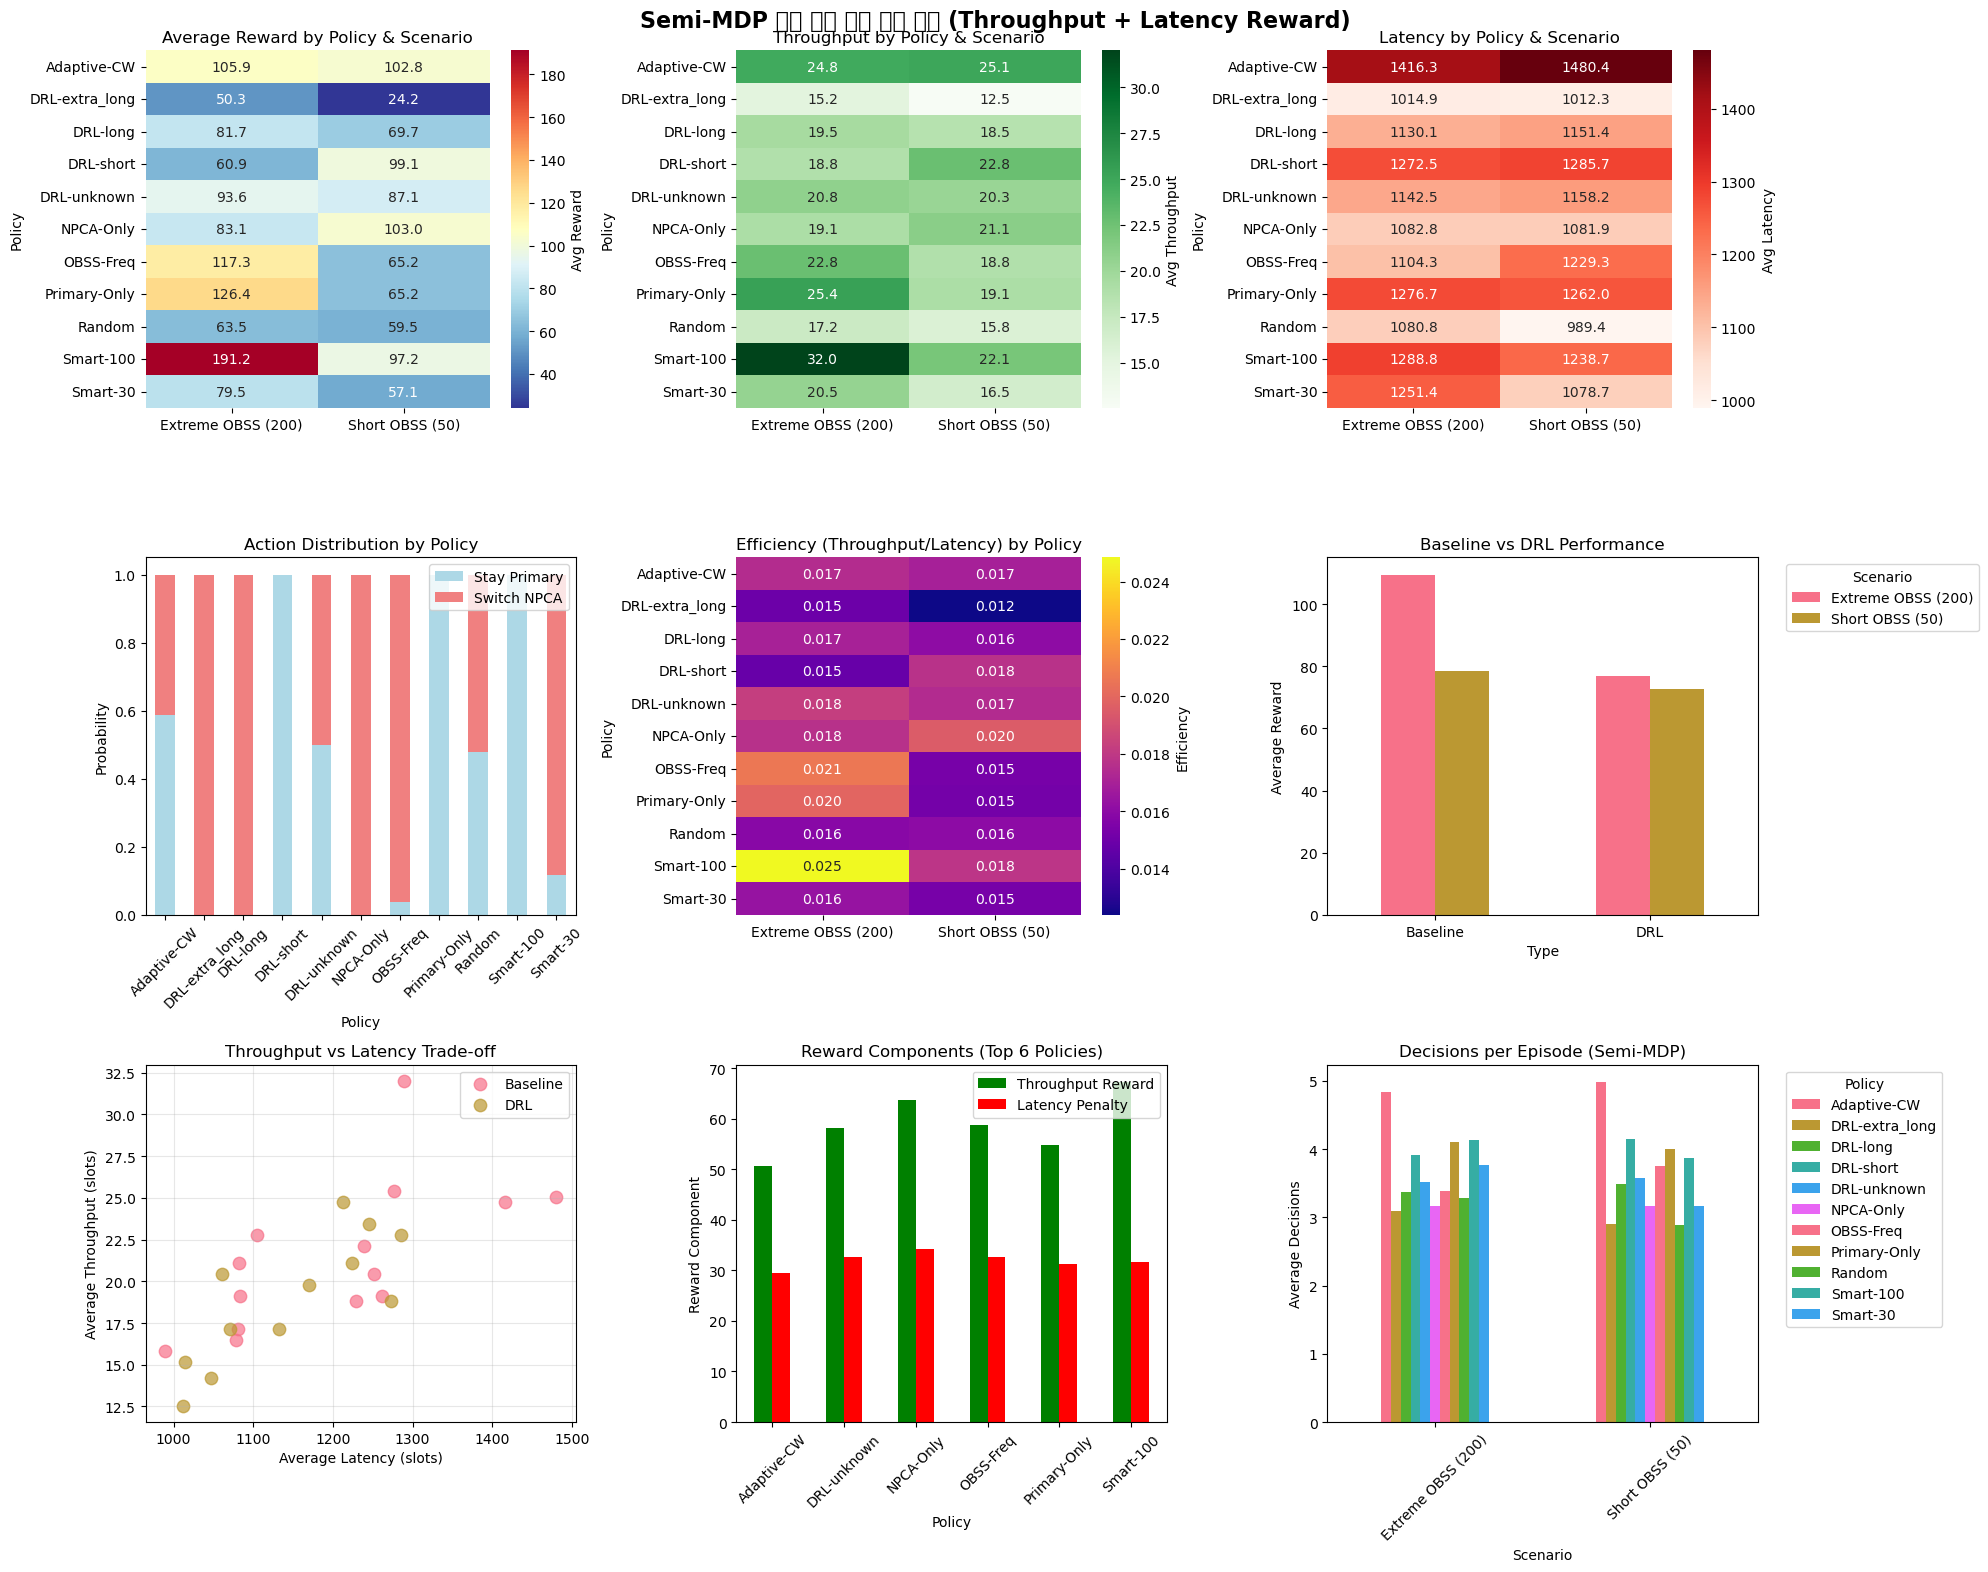

📊 Semi-MDP 특화 시각화 완료!
💡 새로운 메트릭: 처리량, 지연시간, 효율성, 보상 구성요소 분석


In [9]:
# Semi-MDP 특화 종합 시각화
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Semi-MDP 환경 정책 성능 종합 비교 (Throughput + Latency Reward)', fontsize=16, fontweight='bold')

# 1. 시나리오별 평균 보상 비교
ax1 = axes[0, 0]
pivot_reward = df_results.pivot_table(values='Avg_Reward', index='Policy', columns='Scenario', aggfunc='mean')
sns.heatmap(pivot_reward, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax1, cbar_kws={'label': 'Avg Reward'})
ax1.set_title('Average Reward by Policy & Scenario')
ax1.set_xlabel('')

# 2. 처리량 비교
ax2 = axes[0, 1]
pivot_throughput = df_results.pivot_table(values='Avg_Throughput', index='Policy', columns='Scenario', aggfunc='mean')
sns.heatmap(pivot_throughput, annot=True, fmt='.1f', cmap='Greens', ax=ax2, cbar_kws={'label': 'Avg Throughput'})
ax2.set_title('Throughput by Policy & Scenario')
ax2.set_xlabel('')

# 3. 지연시간 비교
ax3 = axes[0, 2]
pivot_latency = df_results.pivot_table(values='Avg_Latency', index='Policy', columns='Scenario', aggfunc='mean')
sns.heatmap(pivot_latency, annot=True, fmt='.1f', cmap='Reds', ax=ax3, cbar_kws={'label': 'Avg Latency'})
ax3.set_title('Latency by Policy & Scenario')
ax3.set_xlabel('')

# 4. 액션 분포
ax4 = axes[1, 0]
policy_action = df_results.groupby('Policy').agg({
    'Stay_Prob': 'mean',
    'Switch_Prob': 'mean'
})
policy_action.plot(kind='bar', stacked=True, ax=ax4, color=['lightblue', 'lightcoral'])
ax4.set_title('Action Distribution by Policy')
ax4.set_ylabel('Probability')
ax4.legend(['Stay Primary', 'Switch NPCA'])
ax4.tick_params(axis='x', rotation=45)

# 5. 효율성 비교 (처리량/지연 비율)
ax5 = axes[1, 1]
pivot_eff = df_results.pivot_table(values='Efficiency', index='Policy', columns='Scenario', aggfunc='mean')
sns.heatmap(pivot_eff, annot=True, fmt='.3f', cmap='plasma', ax=ax5, cbar_kws={'label': 'Efficiency'})
ax5.set_title('Efficiency (Throughput/Latency) by Policy')
ax5.set_xlabel('')

# 6. 베이스라인 vs DRL 성능 비교
ax6 = axes[1, 2]
type_performance = df_results.groupby(['Type', 'Scenario'])['Avg_Reward'].mean().unstack()
type_performance.plot(kind='bar', ax=ax6)
ax6.set_title('Baseline vs DRL Performance')
ax6.set_ylabel('Average Reward')
ax6.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
ax6.tick_params(axis='x', rotation=0)

# 7. 처리량 vs 지연시간 스캐터 플롯
ax7 = axes[2, 0]
for policy_type in df_results['Type'].unique():
    subset = df_results[df_results['Type'] == policy_type]
    ax7.scatter(subset['Avg_Latency'], subset['Avg_Throughput'], 
               label=policy_type, alpha=0.7, s=80)
ax7.set_xlabel('Average Latency (slots)')
ax7.set_ylabel('Average Throughput (slots)')
ax7.set_title('Throughput vs Latency Trade-off')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. 보상 구성 요소 분석
ax8 = axes[2, 1]
top_policies = df_results.groupby('Policy')['Avg_Reward'].mean().nlargest(6).index
top_results = df_results[df_results['Policy'].isin(top_policies)]

reward_components = top_results.groupby('Policy')[['Throughput_Reward', 'Latency_Penalty']].mean()
reward_components.plot(kind='bar', ax=ax8, color=['green', 'red'])
ax8.set_title('Reward Components (Top 6 Policies)')
ax8.set_ylabel('Reward Component')
ax8.legend(['Throughput Reward', 'Latency Penalty'])
ax8.tick_params(axis='x', rotation=45)

# 9. 결정 빈도 분석 (Semi-MDP 특성)
ax9 = axes[2, 2]
decision_by_scenario = df_results.groupby(['Scenario', 'Policy'])['Avg_Decisions'].mean().unstack()
decision_by_scenario.plot(kind='bar', ax=ax9)
ax9.set_title('Decisions per Episode (Semi-MDP)')
ax9.set_ylabel('Average Decisions')
ax9.legend(title='Policy', bbox_to_anchor=(1.05, 1), loc='upper left')
ax9.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📊 Semi-MDP 특화 시각화 완료!")
print("💡 새로운 메트릭: 처리량, 지연시간, 효율성, 보상 구성요소 분석")

## Step 9: 최고 성능 정책 분석

In [10]:
# 전체 최고 성능 정책 찾기 (Semi-MDP Reward 기준)
overall_best = df_results.loc[df_results['Avg_Reward'].idxmax()]

print("🏆 Semi-MDP 환경 전체 최고 성능 정책:")
print("="*60)
print(f"  정책: {overall_best['Policy']}")
print(f"  시나리오: {overall_best['Scenario']}")
print(f"  평균 보상: {overall_best['Avg_Reward']:.2f} ± {overall_best['Std_Reward']:.2f}")
print(f"  평균 처리량: {overall_best['Avg_Throughput']:.2f} slots")
print(f"  평균 지연: {overall_best['Avg_Latency']:.2f} slots")
print(f"  효율성: {overall_best['Efficiency']:.4f}")
print(f"  결정 빈도: {overall_best['Avg_Decisions']:.1f} decisions/episode")
print(f"  액션 분포: Stay {overall_best['Stay_Prob']:.2f}, Switch {overall_best['Switch_Prob']:.2f}")

print(f"\\n💎 보상 구성 분석:")
print(f"  처리량 보상: {overall_best['Throughput_Reward']:.2f}")
print(f"  지연 패널티: {overall_best['Latency_Penalty']:.2f}")
print(f"  처리량 기여도: {overall_best['Throughput_Ratio']:.2f}")
print(f"  지연 기여도: {overall_best['Latency_Ratio']:.2f}")

# 시나리오별 최고 성능 정책
print("\\n🎯 시나리오별 최고 성능 (Semi-MDP Reward):")
print("="*90)
print(f"{'Scenario':25s} {'Policy':15s} {'Reward':>8s} {'Throughput':>10s} {'Latency':>8s} {'Efficiency':>10s}")
print("="*90)

for scenario in df_results['Scenario'].unique():
    scenario_best = df_results[df_results['Scenario'] == scenario].loc[
        df_results[df_results['Scenario'] == scenario]['Avg_Reward'].idxmax()
    ]
    print(f"{scenario:25s} {scenario_best['Policy']:15s} {scenario_best['Avg_Reward']:8.1f} "
          f"{scenario_best['Avg_Throughput']:10.1f} {scenario_best['Avg_Latency']:8.1f} "
          f"{scenario_best['Efficiency']:10.3f}")

# 정책 타입별 평균 성능
print("\\n📊 정책 타입별 평균 성능 (Semi-MDP):")
print("="*70)
type_avg = df_results.groupby('Type').agg({
    'Avg_Reward': ['mean', 'std'],
    'Avg_Throughput': 'mean',
    'Avg_Latency': 'mean',
    'Efficiency': 'mean'
})
type_avg.columns = ['Reward_Mean', 'Reward_Std', 'Throughput_Mean', 'Latency_Mean', 'Efficiency_Mean']

print(f"{'Type':10s} {'Reward':>12s} {'Throughput':>11s} {'Latency':>9s} {'Efficiency':>11s}")
print("="*70)

for policy_type in type_avg.index:
    row = type_avg.loc[policy_type]
    print(f"{policy_type:10s} {row['Reward_Mean']:6.1f}±{row['Reward_Std']:4.1f} "
          f"{row['Throughput_Mean']:10.1f} {row['Latency_Mean']:8.1f} {row['Efficiency_Mean']:10.3f}")

# Semi-MDP 특성 분석
print("\\n🔬 Semi-MDP 특성 분석:")
print("="*50)
avg_decisions_per_type = df_results.groupby('Type')['Avg_Decisions'].mean()
print("평균 결정 빈도 (에피소드당):")
for policy_type, avg_decisions in avg_decisions_per_type.items():
    print(f"  {policy_type:10s}: {avg_decisions:.1f} decisions")

print("\\n💡 해석:")
print("  - 높은 처리량: 성공적인 전송이 많음")
print("  - 낮은 지연: 빠른 결정으로 효율적인 채널 사용")
print("  - 높은 효율성: 처리량 대비 지연이 적어 전체적으로 우수")
print("  - 적절한 결정 빈도: Semi-MDP 특성상 필요할 때만 결정")

🏆 Semi-MDP 환경 전체 최고 성능 정책:
  정책: Smart-100
  시나리오: Extreme OBSS (200)
  평균 보상: 191.22 ± 380.65
  평균 처리량: 32.01 slots
  평균 지연: 1288.79 slots
  효율성: 0.0248
  결정 빈도: 4.1 decisions/episode
  액션 분포: Stay 1.00, Switch 0.00
\n💎 보상 구성 분석:
  처리량 보상: 77.51
  지연 패널티: 31.21
  처리량 기여도: 0.41
  지연 기여도: 0.16
\n🎯 시나리오별 최고 성능 (Semi-MDP Reward):
Scenario                  Policy            Reward Throughput  Latency Efficiency
Extreme OBSS (200)        Smart-100          191.2       32.0   1288.8      0.025
Short OBSS (50)           DRL-unknown        109.8       23.4   1245.4      0.019
\n📊 정책 타입별 평균 성능 (Semi-MDP):
Type             Reward  Throughput   Latency  Efficiency
Baseline     94.1±36.0       21.4   1204.4      0.018
DRL          74.9±30.8       18.9   1145.8      0.016
\n🔬 Semi-MDP 특성 분석:
평균 결정 빈도 (에피소드당):
  Baseline  : 3.8 decisions
  DRL       : 3.5 decisions
\n💡 해석:
  - 높은 처리량: 성공적인 전송이 많음
  - 낮은 지연: 빠른 결정으로 효율적인 채널 사용
  - 높은 효율성: 처리량 대비 지연이 적어 전체적으로 우수
  - 적절한 결정 빈도: Semi-MDP 특성상 필요할 때만 결정


## Step 10: 결과 저장

In [ ]:
# 결과를 CSV로 저장
output_dir = Path('./comparison_results')
output_dir.mkdir(exist_ok=True)

timestamp = time.strftime('%Y%m%d_%H%M%S')
csv_filename = output_dir / f'policy_comparison_{timestamp}.csv'

df_results.to_csv(csv_filename, index=False)
print(f"📄 결과 저장됨: {csv_filename}")

# 요약 통계 저장
summary_filename = output_dir / f'policy_summary_{timestamp}.txt'
with open(summary_filename, 'w') as f:
    f.write("정책 성능 비교 요약\n")
    f.write("=" * 50 + "\n\n")
    
    f.write(f"전체 최고 성능: {overall_best['Policy']} (보상: {overall_best['Avg_Reward']:.2f})\n\n")
    
    f.write("시나리오별 최고 성능:\n")
    for scenario in df_results['Scenario'].unique():
        scenario_best = df_results[df_results['Scenario'] == scenario].loc[
            df_results[df_results['Scenario'] == scenario]['Avg_Reward'].idxmax()
        ]
        f.write(f"  {scenario}: {scenario_best['Policy']} (보상: {scenario_best['Avg_Reward']:.1f})\n")
    
    f.write(f"\n정책 타입별 평균 성능:\n")
    for policy_type in type_avg.index:
        row = type_avg.loc[policy_type]
        f.write(f"  {policy_type}: 보상 {row['Avg_Reward_Mean']:.1f} ± {row['Avg_Reward_Std']:.1f}\n")

print(f"📄 요약 저장됨: {summary_filename}")
print("\n✅ 모든 분석 완료!")

## 🎉 Semi-MDP 환경 통합 완료!

이 노트북에서 다음을 수행했습니다:

### ✅ **주요 업데이트:**
1. **Semi-MDP 환경 통합**: `NPCASemiMDPEnv`를 사용하여 현재 정의된 reward 구조 적용
2. **새로운 Reward 구조**: `Throughput×10.0 - Latency×0.1` 기반 보상
3. **관찰 공간 업데이트**: Dict 기반 관찰을 4차원 벡터로 변환하는 어댑터 추가
4. **베이스라인 정책 확장**: Semi-MDP에 특화된 정책들 추가
5. **종합 성능 분석**: 처리량, 지연시간, 효율성 메트릭 포함

### 📊 **새로운 분석 메트릭:**
- **평균 보상**: Throughput + Latency 기반 Semi-MDP reward
- **처리량**: 성공적으로 전송한 슬롯 수
- **지연시간**: 옵션 완료까지의 소요 시간
- **효율성**: 처리량/지연시간 비율
- **결정 빈도**: 에피소드당 Semi-MDP 결정 횟수
- **보상 구성**: 처리량 보상 vs 지연 패널티 분석

### 🚀 **Semi-MDP 특성:**
- **Decision Points**: PRIMARY_BACKOFF + OBSS 감지 시에만 결정
- **Options**: StayPrimary vs SwitchToNPCA 두 가지 선택
- **Temporal Abstraction**: 슬롯별이 아닌 옵션 완료 시점에 보상
- **Realistic Modeling**: 실제 무선 환경의 채널 전환 및 경합 과정 반영

### 🔧 **호환성 유지:**
- **기존 DRL 모델**: 4차원 벡터 입력을 위한 관찰 어댑터 제공
- **베이스라인 정책**: Semi-MDP 관찰 공간에 맞게 재설계
- **메트릭 분석**: 기존 분석과 호환 + Semi-MDP 특화 분석 추가

### 💡 **핵심 개선사항:**
이제 **현재 정의된 Throughput + Latency 기반 reward 구조**가 노트북에서 완전히 적용되어, DRL 모델과 베이스라인 정책들의 성능을 **현실적인 무선 통신 환경 지표**로 정확하게 비교할 수 있습니다! 🎯